# Verifying the dataset samples

This notebook will use the WISDM view (unbalanced_20Hz_train_test-v1) and will:

1. Apply DFT over dataset windows
2. ...
.
.
.
3. Plot UMAP and T-SNE

In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from librep.datasets.har.loaders import WISDM_UnbalancedView20Hz
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-11 01:17:39.191916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 01:17:39.191936: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# WISDM Loader
loader = WISDM_UnbalancedView20Hz(
    "../../data/views/WISDM/unbalanced_20Hz_train_test-v1", 
    download=False
)
train_val, test = loader.load(concat_train_validation=True, label="standard activity code")

In [4]:
train_val.window_names, train_val.window_slices

(['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'],
 [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)])

In [5]:
# Checking the whole data...
train_val[:][0]

array([[-3.64761350e-01, -9.00995470e-01,  1.98847712e+00, ...,
        -7.46975313e-02, -2.72202574e-02,  3.14904714e-01],
       [ 8.10018945e-02, -5.95542451e-02,  4.29259811e-01, ...,
         6.75210807e-02,  4.06141008e-01,  6.15970864e-01],
       [ 1.92588077e-01, -8.55499056e-01, -1.24274639e+00, ...,
        -1.02323616e-01,  1.00643820e-01,  6.08968376e-01],
       ...,
       [-7.77214630e-01, -7.14180672e-01, -7.65897083e-01, ...,
         6.43874061e-03,  5.18116016e-03,  1.14679768e-02],
       [-1.07346095e+00, -6.14643601e-01, -7.64390203e-01, ...,
         4.95990183e-03,  2.79996918e-03, -4.58106825e-03],
       [-5.03658598e-01, -2.43421138e-01, -3.68060344e-01, ...,
         1.17379544e-03,  4.02741207e-03,  1.58229136e-02]])

In [6]:
train_val[0][0].shape

(360,)

In [7]:
train_val.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,user,standard activity code
0,-0.364761,-0.900995,1.988477,0.504245,-2.074267,-4.365631,-0.503460,1.585056,-0.192807,-1.778517,...,0.021654,-0.008257,-0.392786,-0.329143,-0.074698,-0.027220,0.314905,0,1600,2
1,0.081002,-0.059554,0.429260,1.072248,-2.011736,-4.792650,-2.087036,0.663866,0.317017,-1.504834,...,0.345166,0.294343,-0.417068,-0.172208,0.067521,0.406141,0.615971,0,1600,2
2,0.192588,-0.855499,-1.242746,0.316417,-1.833108,-4.946311,1.429507,1.555702,-1.230934,-2.758278,...,0.341863,0.039910,-0.253467,-0.607339,-0.102324,0.100644,0.608968,0,1600,2
3,1.506239,-1.887573,-0.375515,0.282729,-2.745547,-5.598461,-1.923976,1.519264,0.538521,-2.826598,...,0.408067,0.268658,-0.341150,-0.359142,-0.065309,-0.015974,0.365056,0,1600,2
4,-0.494237,-0.791543,0.976555,1.730751,-4.135104,-7.033570,-3.470397,-1.347896,0.434743,0.326745,...,-0.459501,0.421399,-0.182202,-0.406128,-0.590792,-0.174049,0.307581,0,1600,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,-0.705972,-0.726914,-0.808348,-0.727646,-0.519297,-0.706294,-0.778460,-0.935760,-0.656630,-0.765051,...,0.015264,0.003391,-0.007575,0.000763,0.015584,-0.014311,-0.016027,4,1635,1
10819,-0.608502,-0.795883,-0.552300,-0.851302,-0.894535,-0.706040,-0.784716,-0.855779,-0.704870,-0.683281,...,-0.003144,-0.002943,0.005729,-0.010290,-0.006023,-0.006458,-0.001189,4,1635,1
10820,-0.777215,-0.714181,-0.765897,-0.765035,-0.697754,-0.852415,-0.749396,-0.637518,-0.757676,-0.702906,...,-0.001254,0.006774,-0.001247,0.001032,0.006439,0.005181,0.011468,4,1635,1
10821,-1.073461,-0.614644,-0.764390,-0.546810,-0.874834,-0.619953,-0.698473,-0.924804,-0.704255,-0.736017,...,0.004119,0.000570,-0.035448,-0.028324,0.004960,0.002800,-0.004581,4,1635,1


In [8]:
train_val.data['standard activity code'] = train_val.data['standard activity code'].astype('int')
test.data['standard activity code'] = test.data['standard activity code'].astype('int')

In [9]:
train_val.data.describe()

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,standard activity code
count,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,...,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000
mean,-0.105190,-0.097713,-0.061938,-0.079331,-0.136161,-0.210600,-0.165041,-0.188723,-0.155305,-0.174346,...,-0.009272,-0.006242,-0.007047,-0.015948,-0.008439,-0.007900,-0.020075,-0.012868,-0.004171,2.775293
std,5.286732,5.228431,5.265864,5.232591,5.228650,5.236718,5.217191,5.257057,5.202087,5.163136,...,0.930740,0.944661,0.928317,0.972496,0.965848,0.942276,0.946214,0.959424,0.978382,2.316277
min,-23.451251,-21.201263,-20.116584,-20.680624,-21.254168,-20.442931,-21.703637,-21.339970,-20.947055,-21.019733,...,-7.664606,-9.737739,-10.652704,-12.109685,-8.862850,-9.235783,-11.865164,-10.336521,-10.386520,0.000000
25%,-3.088468,-3.096602,-3.044383,-3.068328,-3.130675,-3.222249,-3.126423,-3.171965,-3.081922,-3.095960,...,-0.177458,-0.165249,-0.171662,-0.183985,-0.170109,-0.179099,-0.186572,-0.188080,-0.180611,1.000000
50%,-0.093611,-0.143521,-0.131110,-0.081606,-0.125065,-0.136131,-0.111269,-0.114529,-0.122918,-0.128595,...,-0.000982,-0.000710,-0.000750,-0.000941,-0.000973,-0.001175,-0.001541,-0.001194,-0.001025,2.000000
75%,3.122589,3.127022,3.108404,3.048547,3.062237,3.027269,3.060705,3.111957,3.060319,3.080721,...,0.160202,0.165026,0.170143,0.167101,0.175787,0.162238,0.149386,0.166146,0.171061,5.000000
max,20.248555,19.779669,21.459666,22.167043,20.678980,22.783820,20.001859,22.675548,19.449384,21.842399,...,8.695147,8.765377,8.302051,9.979406,12.063560,8.778277,8.056754,10.651924,10.160658,6.000000


In [10]:
labels = {0: "Sit", 1: "Stand", 2: "Walk", 3: "Stair up", 4: "Stair down", 5: "Run", 6: "stair up and down"}

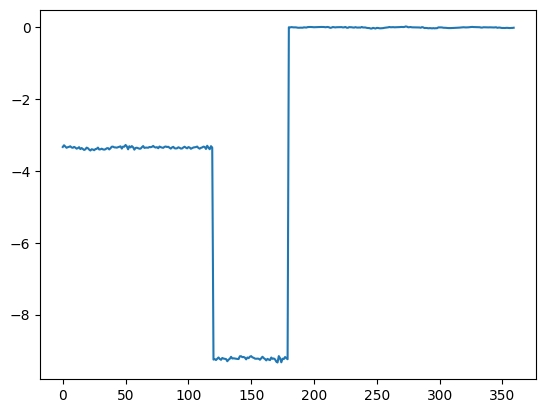

In [11]:
plt.plot(train_val[2000][0])

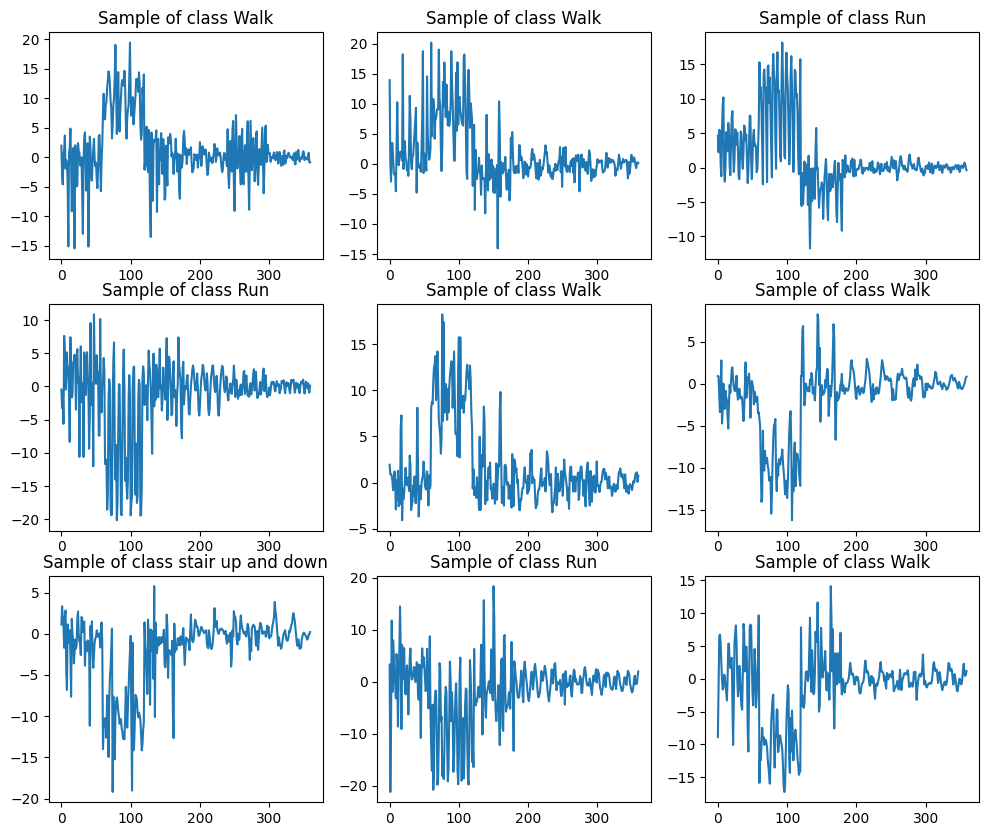

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i in range(3):
    for j in range(3):
        x = np.random.randint(10823, size=1)
        classe = train_val[x[0]][1]
        y = labels[classe]
        axs[i,j].set_title('Sample of class {}'.format(y))
        axs[i,j].plot(train_val[x[0]][0])
plt.show()

In [13]:
# Create the objects
fft_transform = FFT(centered=True)

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], new_window_name_prefix="fft."
)

In [14]:
# Transform it and generate a new dataset!
train_val_fft = transformer(train_val)
test_fft = transformer(test)

In [15]:
# Checking the whole data...
train_val_fft[:][0]

array([[5.20076066e+01, 5.82324914e+00, 4.76082845e+00, ...,
        1.04994229e+00, 7.98717087e-01, 5.13835975e-01],
       [7.54114234e+01, 4.01340311e+00, 4.75551894e+00, ...,
        8.95583885e-01, 1.28333190e+00, 9.87727967e-01],
       [7.73304435e+01, 4.47639887e-01, 2.55949017e+00, ...,
        7.44211880e-01, 1.04750513e+00, 8.14588732e-01],
       ...,
       [4.37781132e+01, 5.62231617e-01, 9.64231029e-02, ...,
        3.77770407e-02, 4.46186807e-02, 2.13851869e-02],
       [4.38202792e+01, 2.03158487e+00, 1.56536189e+00, ...,
        3.84286164e-02, 7.90887029e-02, 7.94048263e-02],
       [1.22347813e+01, 6.09052263e+00, 3.00503782e+00, ...,
        2.39051305e-02, 3.53183569e-02, 2.13291427e-02]])

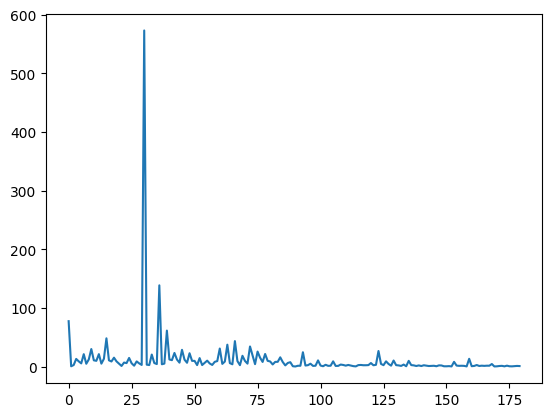

In [16]:
plt.plot(train_val_fft[2][0])

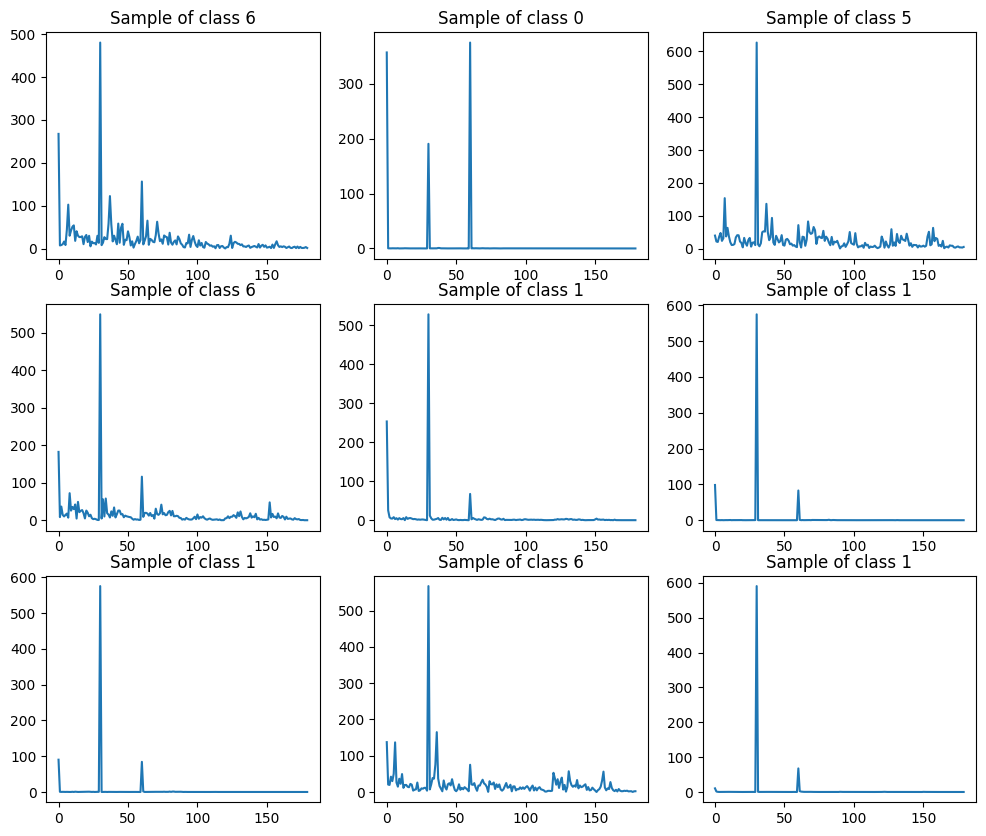

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i in range(3):
    for j in range(3):
        x = np.random.randint(10823, size=1)
        classe = train_val_fft[x[0]][1]
        y = labels[classe]
        axs[i,j].set_title('Sample of class {}'.format(classe))
        axs[i,j].plot(train_val_fft[x[0]][0])
plt.show()

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [18]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    # normalize='true'
)

### RandomForest (Domínio do Tempo)

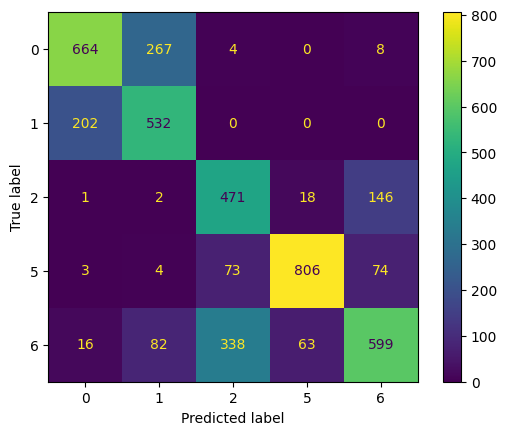

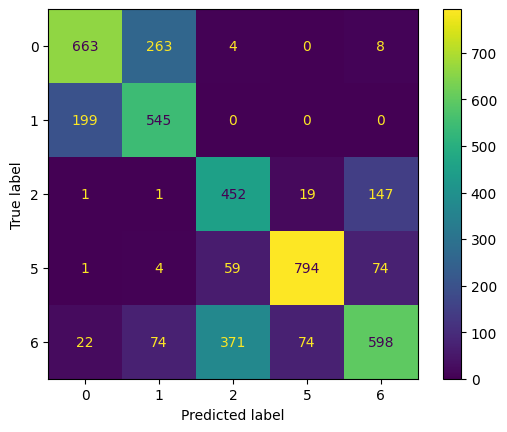

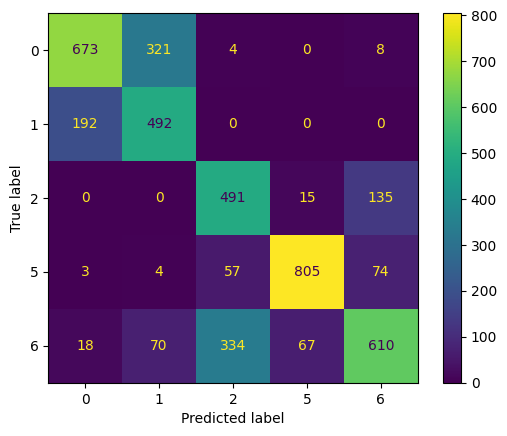

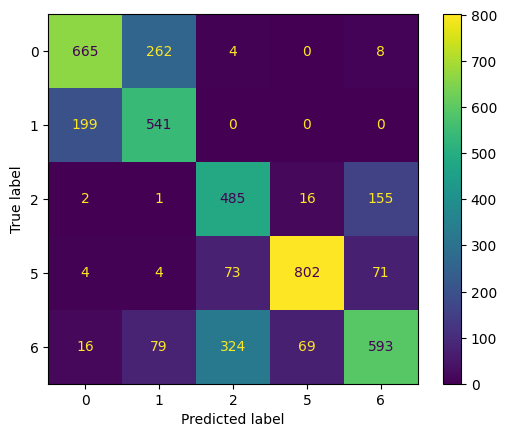

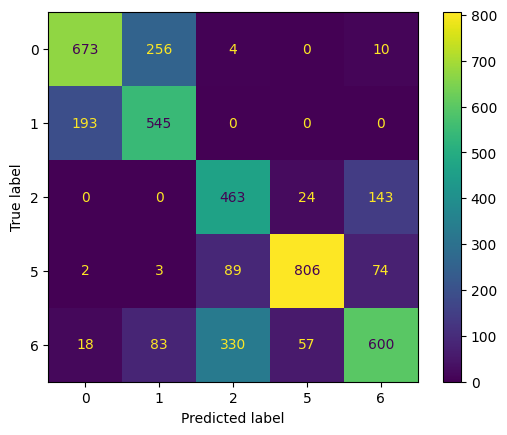

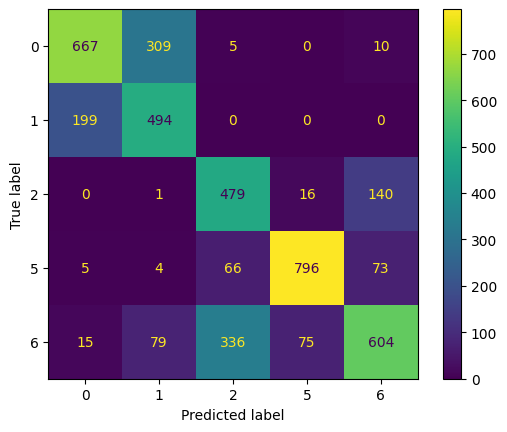

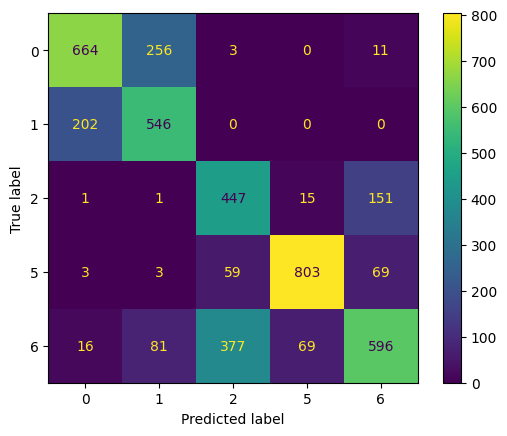

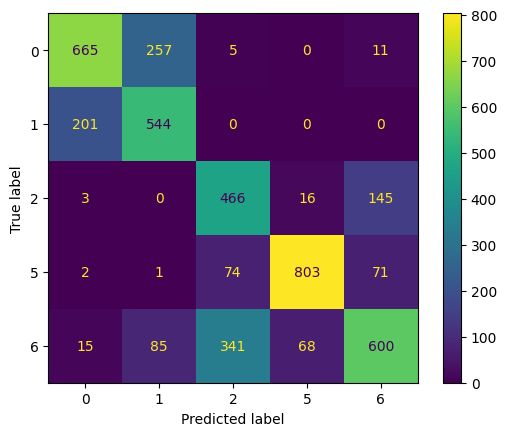

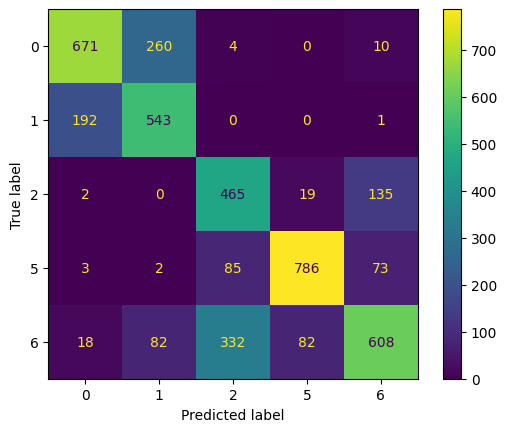

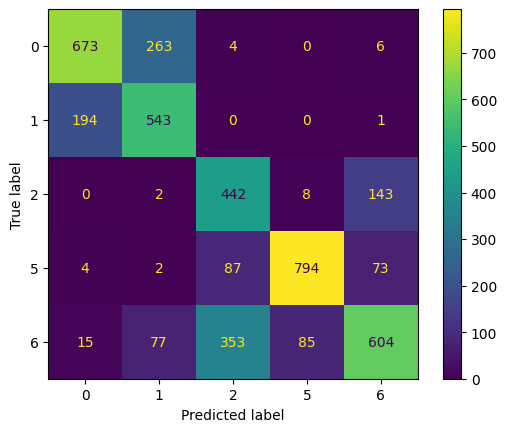

Mean accuracy (10 runs): 0.7014. Mean f1-score: 0.7035
Standard deviation accuracy (10 runs): 0.0034. Standard deviation f1-score: 0.0034


In [19]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_val, [test])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### RandomForest (Domínio da Frequência)

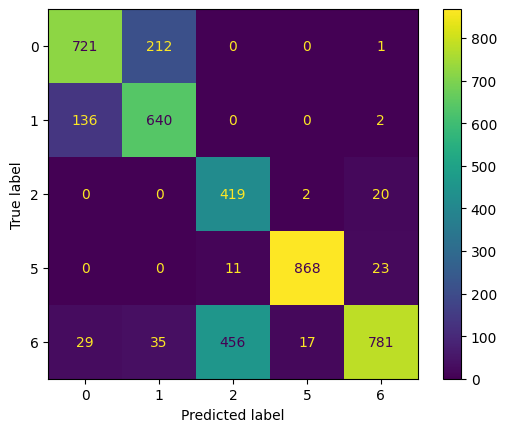

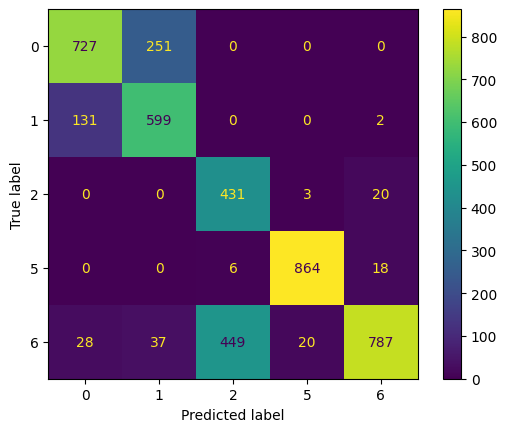

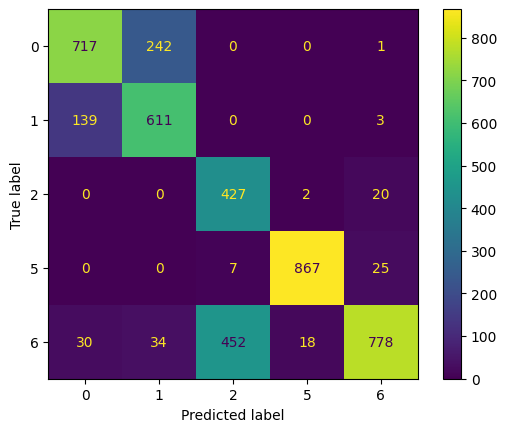

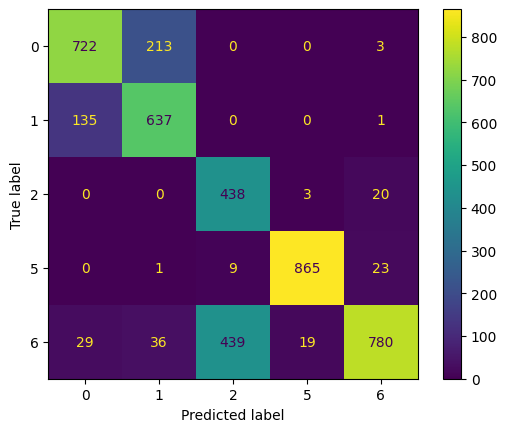

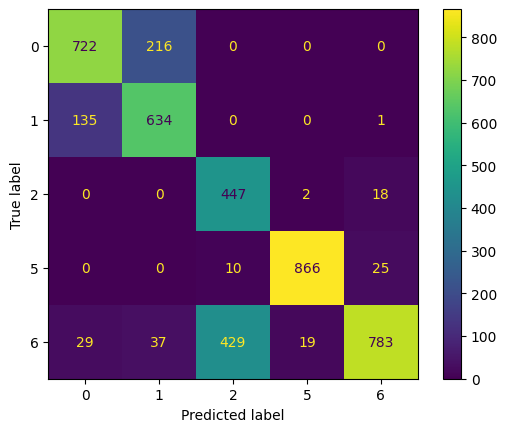

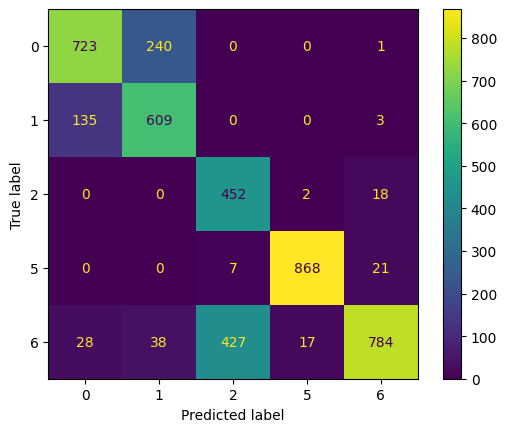

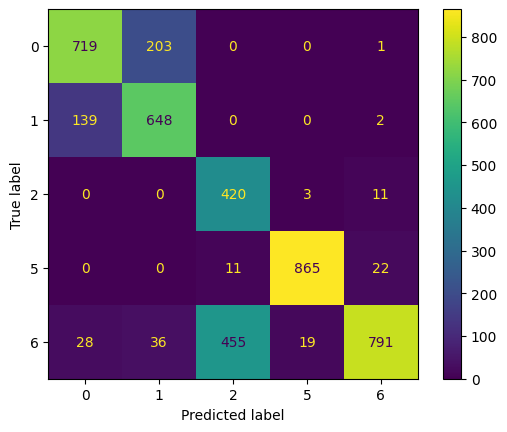

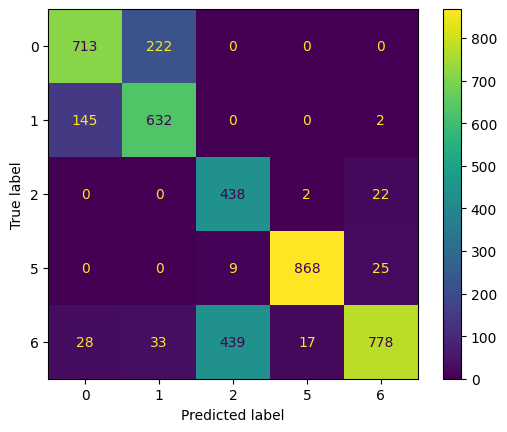

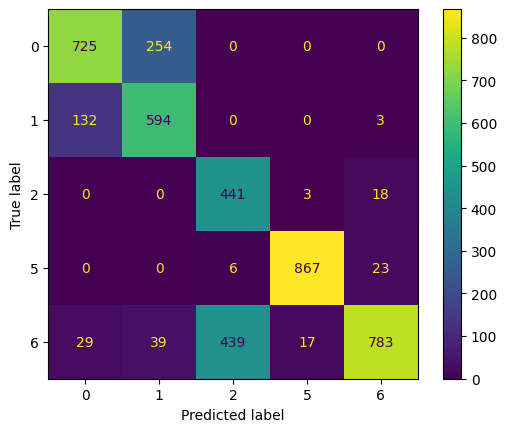

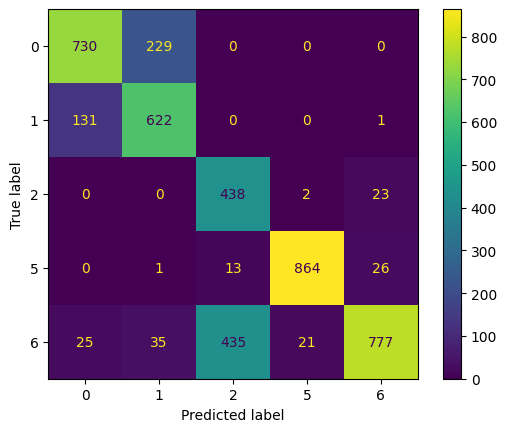

Mean accuracy (10 runs): 0.7839. Mean f1-score: 0.7885
Standard deviation accuracy (10 runs): 0.0037. Standard deviation f1-score: 0.0035


In [20]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_val_fft, [test_fft])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### SVM

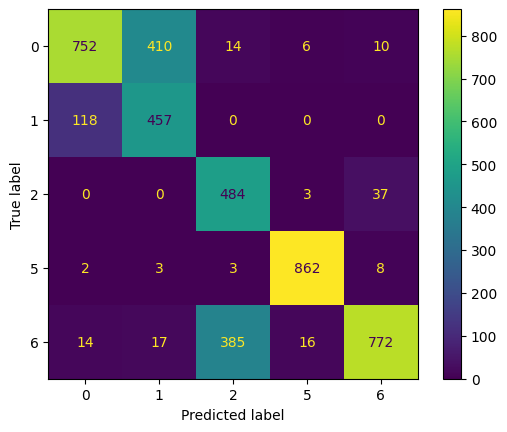

Mean accuracy (1 runs): 0.7608. Mean f1-score: 0.7672
Standard deviation accuracy (1 runs): 0.0000. Standard deviation f1-score: 0.0000


In [21]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_val_fft, [test_fft])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (1 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### KNN

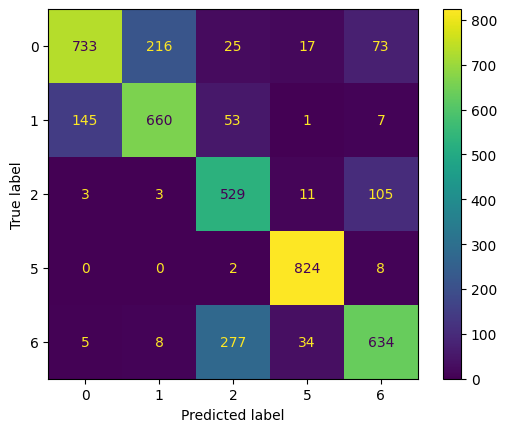

Mean accuracy (1 run): 0.7729. Mean f1-score: 0.7728
Standard deviation accuracy (1 run): 0.0000. Standard deviation f1-score: 0.0000


In [22]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_val_fft, [test_fft])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (1 run): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (1 run): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

## Plot UMAP and T-SNE

In [23]:
def plot(df, figsize: tuple = (8, 8), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label)
    ax.legend()
    plt.title(title)
    plt.show()

In [24]:
labels = {0: "Sit", 1: "Stand", 2: "Walk", 3: "Stair up", 4: "Stair down", 5: "Run", 6: "stair up and down"}
print(labels)

{0: 'Sit', 1: 'Stand', 2: 'Walk', 3: 'Stair up', 4: 'Stair down', 5: 'Run', 6: 'stair up and down'}


### UMAP (Domínio do Tempo)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


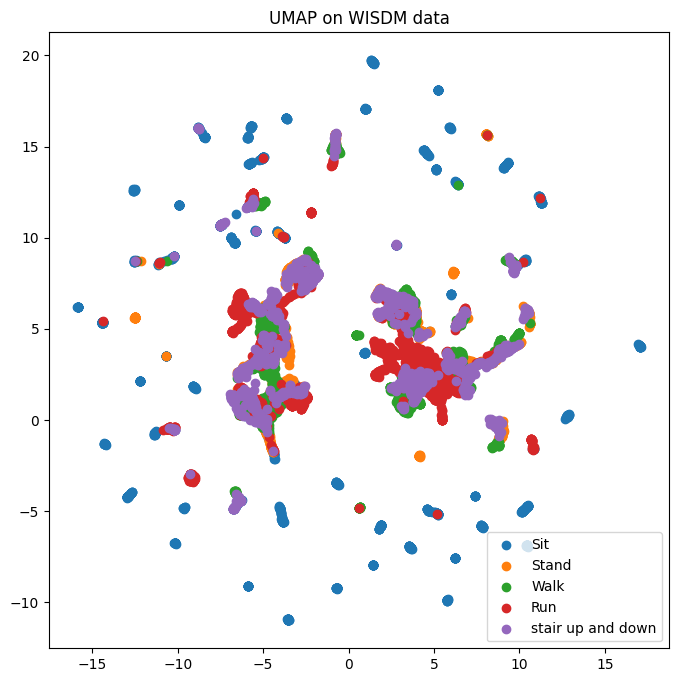

In [25]:
model = UMAP(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val[:][0]), columns=["x", "y"])
result["label"] = train_val[:][1]
plot(result, title="UMAP on WISDM data", labels = labels)

### T-SNE (Domínio do Tempo)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


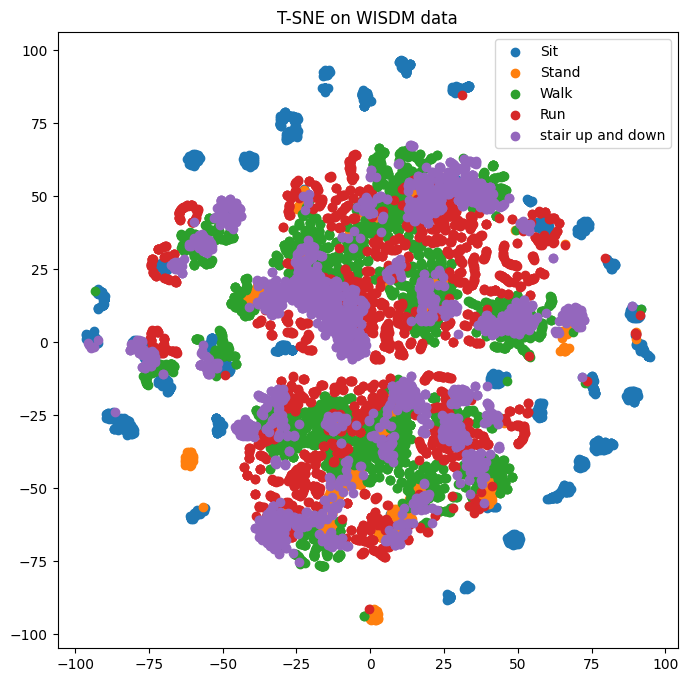

In [26]:
model = TSNE(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val[:][0]), columns=["x", "y"])
result["label"] = train_val[:][1]
plot(result, title="T-SNE on WISDM data", labels=labels)

### UMAP (Domínio da Frequência)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


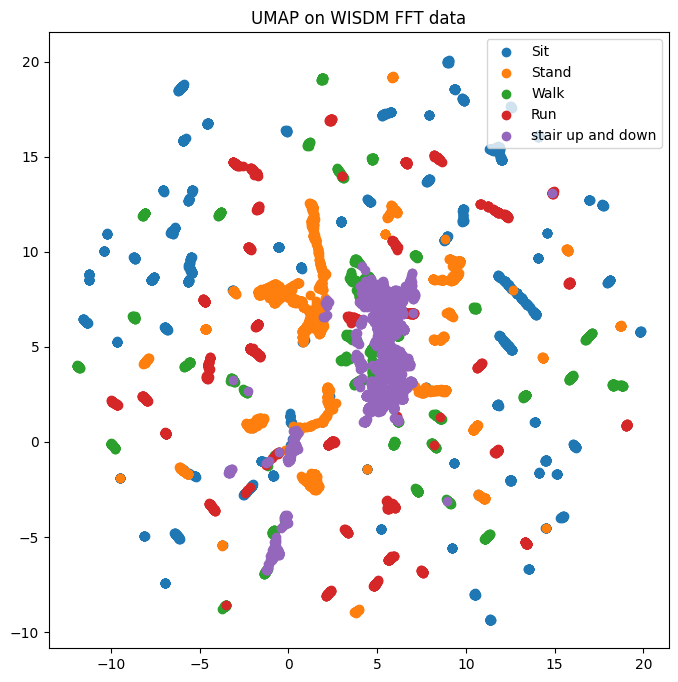

In [27]:
model = UMAP(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
result["label"] = train_val_fft[:][1]
plot(result, title="UMAP on WISDM FFT data", labels = labels)

### T-SNE (Domínio da Frequência)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


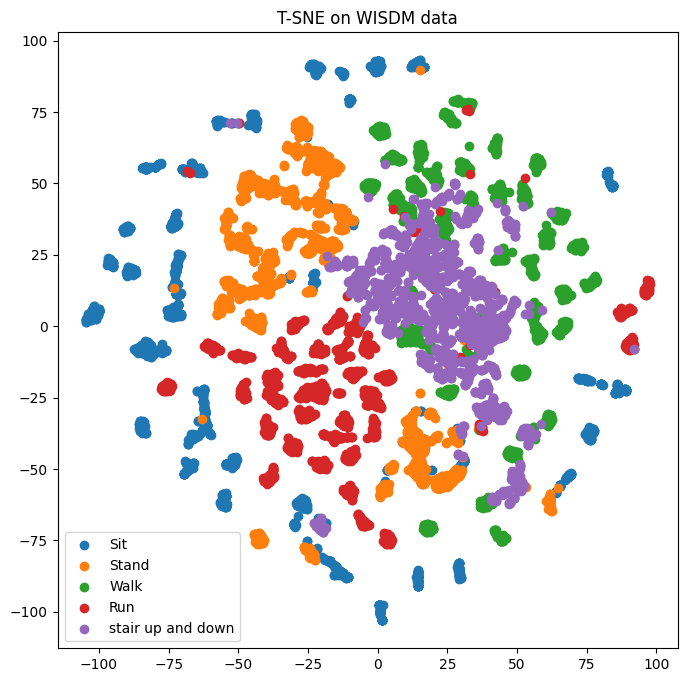

In [29]:
model = TSNE(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
result["label"] = train_val_fft[:][1]
plot(result, title="T-SNE on WISDM data", labels=labels)